In [1]:
import pandas as pd
from datetime import datetime,timedelta
import glob,os.path,re,json
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import numpy as np
import requests
import sys
import time
import random
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()
import MySQLdb

In [2]:
#glob 특정 파일만 추출하기
def load_file(path):
    file_list = glob.glob(path)
    for index,fname in enumerate(file_list):
        tmp_result = get_df_from_csv(fname)        
        if index == 0 :
            final_result = tmp_result
        else:
            final_result= pd.concat([final_result,tmp_result],ignore_index=True)
        print(f'{index}번째 파일 완료')    
    return final_result

def get_df_from_csv(csvpath):
    tmp_df=pd.read_csv(csvpath)
    tmp_df['Unnamed: 0']=pd.to_datetime(tmp_df['Unnamed: 0'],format='%Y%m%d')
    tmp_df.set_index('Unnamed: 0',inplace=True)
    # 날짜를 index로 설정
    index_lsts = tmp_df.index
    for i_0, index in enumerate(index_lsts):
        seogwipo_dict = eval(tmp_df.loc[index,'서귀포시'])
        jeju_dict = eval(tmp_df.loc[index,'제주시'])
        key_lsts = jeju_dict.keys()
        #서귀포시 df
        for i_1,key in enumerate(key_lsts):
            test_df = pd.DataFrame(seogwipo_dict[key]['list'])
            if i_1 == 0 :
                result1 = test_df
            else:
                result1 = pd.concat([result1,test_df],ignore_index=True)

        #제주시 df
        for i_2,v in enumerate(key_lsts):
            test_df2=pd.DataFrame(jeju_dict[v]['list'])
            if i_2 == 0:
                result2 = test_df2
            else:
                result2=pd.concat([result2,test_df2],ignore_index=True)

        total_result = pd.concat([result1,result2],ignore_index=True)
        total_result['datetime'] = index
        if i_0 == 0:
            final_result = total_result
        else:
            final_result = pd.concat([final_result,total_result],ignore_index=True)
        
    return final_result

def get_df_by_condition(df,localname,**kargs):
    real_local_name = '제주특별자치도 ' + localname
    key_lsts=kargs.keys()
    total_condition = None
    for index,key in enumerate(key_lsts):
        tmp_condtion = (df[key] == kargs[key])
        if index == 0 :
            total_condition = tmp_condtion
        else:
            total_condition = total_condition & tmp_condtion
    if total_condition is not None:
        conditions = (df['AREA_NM']==real_local_name) & total_condition
    else:
        conditions = (df['AREA_NM']==real_local_name)
    result_df = df[conditions]
    return result_df

#저번달 카테고리별(음식점,관광지,숙박) 검색량 상위 num 퍼센트 리스트 가져오기
def get_last_month_top_numpercent_lsts(df,category,num):
    jeju_category = get_df_by_condition(df,'제주시',KTO_CATE_MCLS_NM_1=category,month=datetime.now().month-1)
    jeju_category_group=jeju_category.groupby(['ITS_BRO_NM'])['SRCH_CNT'].sum()
    jeju_toppercent = jeju_category_group.sort_values(ascending=False)[:int(len(jeju_category_group)*num)]

    seogwipo_category = get_df_by_condition(df,'서귀포시',KTO_CATE_MCLS_NM_1=category,month=datetime.now().month-1)
    seogwipo_category_group=seogwipo_category.groupby(['ITS_BRO_NM'])['SRCH_CNT'].sum()
    seogwipo_toppercent = seogwipo_category_group.sort_values(ascending=False)[:int(len(seogwipo_category_group)*num)]

    return jeju_toppercent,seogwipo_toppercent

#저번달 카테고리별(음식점,관광지,숙박) 검색량 하위 num 퍼센트 리스트 가져오기
def get_last_month_bottom_numpercent_lsts(df,category,num):
    jeju_category = get_df_by_condition(df,'제주시',KTO_CATE_MCLS_NM_1=category,month=datetime.now().month-1)
    jeju_category_group=jeju_category.groupby(['ITS_BRO_NM'])['SRCH_CNT'].sum()
    jeju_bottompercent = jeju_category_group.sort_values(ascending=True)[:int(len(jeju_category_group)*num)]

    seogwipo_category = get_df_by_condition(df,'서귀포시',KTO_CATE_MCLS_NM_1=category,month=datetime.now().month-1)
    seogwipo_category_group=seogwipo_category.groupby(['ITS_BRO_NM'])['SRCH_CNT'].sum()
    seogwipo_bottompercent = seogwipo_category_group.sort_values(ascending=True)[:int(len(seogwipo_category_group)*num)]

    return jeju_bottompercent,seogwipo_bottompercent

#월별 몇주차인지 구하는 함수
def get_week_no(datetime):
    firstday = datetime.replace(day=1)
    if firstday.weekday() == 6:
        origin = firstday
    elif firstday.weekday() < 3:
        origin = firstday - timedelta(days=firstday.weekday() + 1)
    else:
        origin = firstday + timedelta(days=6-firstday.weekday())
    return (datetime - origin).days // 7 + 1




In [1]:
def changeCheckedvalue(df,changedict):
    if df['Name'] in changedict:
        return changedict.get(df['Name'])
    else:
        return df['ID']
        

In [3]:
path = './datalab/2022*.csv'

In [4]:
result = load_file(path=path)

0번째 파일 완료
1번째 파일 완료
2번째 파일 완료
3번째 파일 완료
4번째 파일 완료
5번째 파일 완료
6번째 파일 완료


In [5]:
result['AREA_NM'].value_counts()

제주특별자치도 제주시     295962
제주특별자치도 서귀포시    261864
Name: AREA_NM, dtype: int64

In [6]:
#weekday 0:월,1:화,2:수,3:목,4:금,5:토,6:일
result['weekday']=result['datetime'].apply(lambda x: x.weekday())
result['month'] =result['datetime'].apply(lambda x: x.month)
result['week_no']=result['datetime'].apply(get_week_no)

In [7]:
#제주국제공항 삭제
jeju_airport_index=result[result['ITS_BRO_NM'] == '제주국제공항'].index
result_drop1=result.drop(index=jeju_airport_index)

In [8]:
mapper = {
    '역사관광':'관광지',
    '체험관광':'관광지',
    '문화관광':'관광지',
    '레저스포츠':'관광지',
    '쇼핑':'관광지',
    '기타관광':'관광지',
    '자연관광':'관광지',
    '음식':'음식점',
    '숙박':'숙박'

}
result_drop1['KTO_CATE_MCLS_NM_1']=result_drop1['KTO_CATE_MCLS_NM'].map(mapper)

In [9]:
#월별 & 지역별 & 대분류별 검색량 집계
group_by_df=result_drop1.groupby(['month','AREA_NM','KTO_CATE_MCLS_NM_1'])['SRCH_CNT'].sum()
tmp=group_by_df.reset_index()
tmp_jeju = get_df_by_condition(tmp,'제주시')
tmp_seogwipo = get_df_by_condition(tmp,'서귀포시')
jeju_month_search=tmp_jeju.pivot(
    index='month',
    columns='KTO_CATE_MCLS_NM_1',
    values='SRCH_CNT'
)
seogwipo_month_search = tmp_seogwipo.pivot(
    index='month',
    columns='KTO_CATE_MCLS_NM_1',
    values='SRCH_CNT'
)

In [10]:
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [11]:
x_value=jeju_month_search.index

C:\Users\TJ\AppData\Local\Temp\ipykernel_15076\3886997079.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


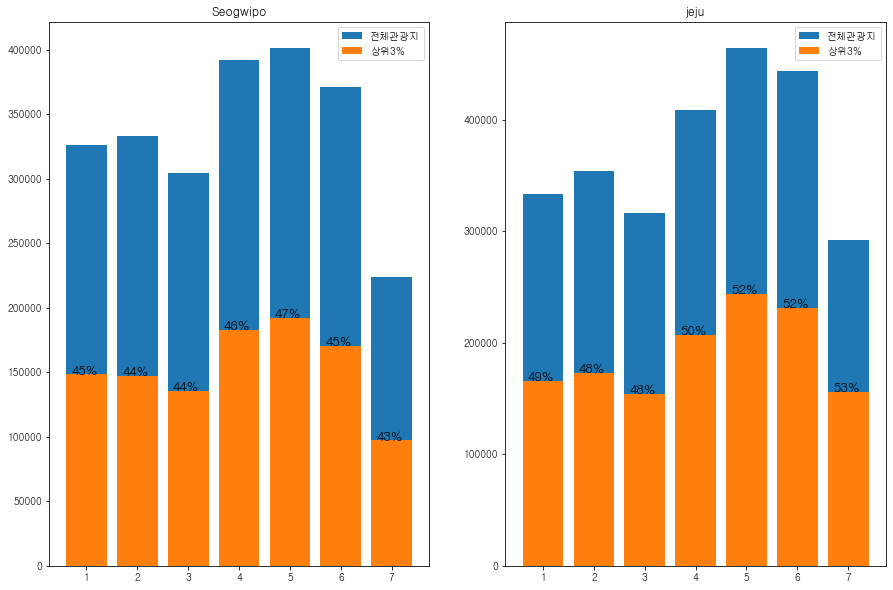

In [40]:
#제주도 관광지 검색 상위1퍼센트가 전체 검색에서 차지하는 비율 시각화
bar_lsts2 = []
for i in range(1,8):
    jeju_tour = get_df_by_condition(result_drop1,'제주시',KTO_CATE_MCLS_NM_1='관광지',month=i)
    jeju_tour_group=jeju_tour.groupby(['ITS_BRO_NM'])['SRCH_CNT'].sum()
    bar_lsts2.append(jeju_tour_group.sort_values(ascending=False)[:int(len(jeju_tour_group)*0.03)].sum())

seogwipo_bar_lsts2 = []
for i in range(1,8):
    seogwipo_tour = get_df_by_condition(result_drop1,'서귀포시',KTO_CATE_MCLS_NM_1='관광지',month=i)
    seogwip_tour_group=seogwipo_tour.groupby(['ITS_BRO_NM'])['SRCH_CNT'].sum()
    seogwipo_bar_lsts2.append(seogwip_tour_group.sort_values(ascending=False)[:int(len(seogwip_tour_group)*0.03)].sum())

fig,axes =plt.subplots(1,2,figsize=(15,10))
ax = axes.flatten()
ax[0].bar(x_value,seogwipo_month_search.loc[:,'관광지'].values,label='전체관광지')
ax[0].bar(x_value,seogwipo_bar_lsts2,label='상위3%')
for i in range(len(x_value)):
    ax[0].text(x = x_value[i]-0.3 , y = seogwipo_bar_lsts2[i]+0.1, s = str(int((seogwipo_bar_lsts2[i]/seogwipo_month_search.loc[:,'관광지'].values[i])*100))+'%', size = 13)
ax[0].set_title('Seogwipo')
ax[0].legend()


ax[1].bar(x_value,jeju_month_search.loc[:,'관광지'].values,label='전체관광지')
ax[1].bar(x_value,bar_lsts2,label='상위3%')
# Text on the top of each bar
for i in range(len(x_value)):
    ax[1].text(x = x_value[i]-0.3 , y = bar_lsts2[i]+0.1, s = str(int((bar_lsts2[i]/jeju_month_search.loc[:,'관광지'].values[i])*100))+'%', size = 13)
ax[1].set_title('jeju')
ax[1].text
ax[1].legend()

fig.show()

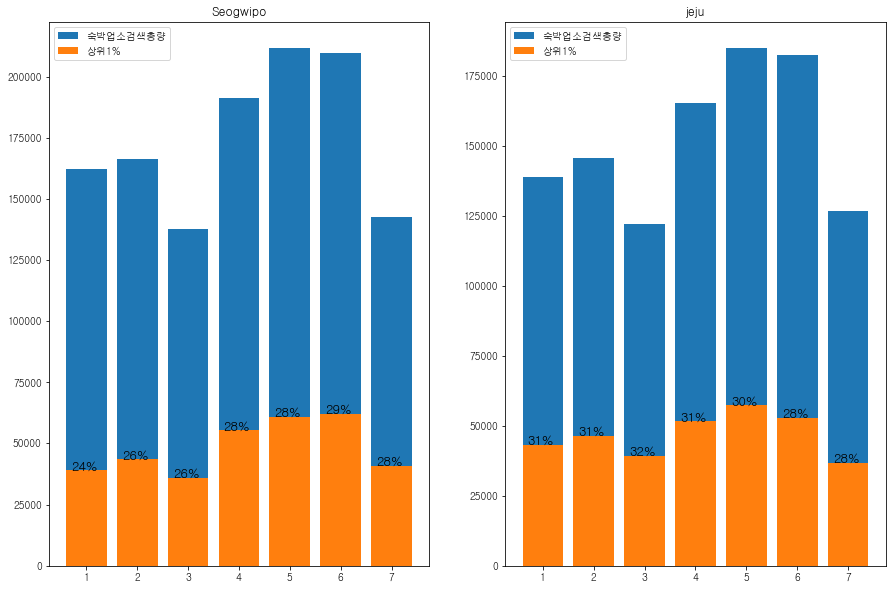

In [13]:
bar_lsts3 = []
for i in range(1,8):
    jeju_stay = get_df_by_condition(result_drop1,'제주시',KTO_CATE_MCLS_NM_1='숙박',month=i)
    jeju_stay_group=jeju_stay.groupby(['ITS_BRO_NM'])['SRCH_CNT'].sum()
    bar_lsts3.append(jeju_stay_group.sort_values(ascending=False)[:int(len(jeju_stay_group)*0.01)].sum())

seogwipo_bar_lsts3 = []
for i in range(1,8):
    seogwipo_stay = get_df_by_condition(result_drop1,'서귀포시',KTO_CATE_MCLS_NM_1='숙박',month=i)
    seogwip_stay_group=seogwipo_stay.groupby(['ITS_BRO_NM'])['SRCH_CNT'].sum()
    seogwipo_bar_lsts3.append(seogwip_stay_group.sort_values(ascending=False)[:int(len(seogwip_stay_group)*0.01)].sum())

fig,axes =plt.subplots(1,2,figsize=(15,10))
ax = axes.flatten()
ax[0].bar(x_value,seogwipo_month_search.loc[:,'숙박'].values,label='숙박업소검색총량')
ax[0].bar(x_value,seogwipo_bar_lsts3,label='상위1%')
for i in range(len(x_value)):
    ax[0].text(x = x_value[i]-0.3 , y = seogwipo_bar_lsts3[i]+0.1, s = str(int((seogwipo_bar_lsts3[i]/seogwipo_month_search.loc[:,'숙박'].values[i])*100))+'%', size = 13)
ax[0].set_title('Seogwipo')
ax[0].legend()


ax[1].bar(x_value,jeju_month_search.loc[:,'숙박'].values,label='숙박업소검색총량')
ax[1].bar(x_value,bar_lsts3,label='상위1%')
# Text on the top of each bar
for i in range(len(x_value)):
    ax[1].text(x = x_value[i]-0.3 , y = bar_lsts3[i]+0.1, s = str(int((bar_lsts3[i]/jeju_month_search.loc[:,'숙박'].values[i])*100))+'%', size = 13)
ax[1].set_title('jeju')
ax[1].text
ax[1].legend()

In [41]:
jejutour_top3percent,seogwipotour_top3percent = get_last_month_top_numpercent_lsts(result_drop1,'관광지',0.03)
jejustay_top1percent,seogwipostay_top1percent = get_last_month_top_numpercent_lsts(result_drop1,'숙박',0.01)

In [42]:
j_df1 =pd.DataFrame(jejutour_top3percent)
s_df1 = pd.DataFrame(seogwipotour_top3percent)

j_df2 = pd.DataFrame(jejustay_top1percent)
s_df2 = pd.DataFrame(seogwipostay_top1percent)


In [43]:
j_df1

,SRCH_CNT
ITS_BRO_NM,
동문재래시장,16895
함덕해수욕장,15127
협재해수욕장,14951
이호테우해변,10591
곽지해수욕장,10033
아르떼뮤지엄제주,7622
금능해수욕장,7352
김녕해수욕장,6925
스누피가든,6150


In [44]:
s_df1

,SRCH_CNT
ITS_BRO_NM,
서귀포매일올레시장,14601
성산일출봉,9498
아쿠아플라넷제주,6793
오설록티뮤지엄,6751
중문색달해변,6019
섭지코지,5424
표선해수욕장,4828
주상절리대,4339
성산포종합여객터미널,4285


In [45]:
j_df2

,SRCH_CNT
ITS_BRO_NM,
그랜드하얏트제주,5670
소노벨제주,3639
한화리조트제주,3220
메종글래드제주호텔,3014
라마다프라자제주호텔,2795
신라스테이제주,1842
라마다제주시티홀호텔,1719
롯데시티호텔제주,1715
호텔리젠트마린,1530


In [46]:
s_df2

,SRCH_CNT
ITS_BRO_NM,
신라호텔제주,4596
휘닉스제주,4323
소노캄제주,4280
제주신화월드랜딩리조트관,3839
금호리조트제주,3765
롯데호텔제주점,3709
해비치호텔,3480
제주부영호텔&리조트,3323
제주신화월드신화리조트관,3296


In [47]:
j_df1.reset_index(inplace=True)
s_df1.reset_index(inplace=True)
j_df2.reset_index(inplace=True)
s_df2.reset_index(inplace=True)

In [48]:
tour_concat =  pd.concat([j_df1,s_df1],axis=0,ignore_index=True)
stay_concat = pd.concat([j_df2,s_df2],axis=0,ignore_index=True)

In [49]:
# 1차 검색 제주 000 
url = 'https://map.naver.com/v5/api/search'
params = {
    'calller': 'pcweb',
    'query': '',
    'type': 'all',
    'searchCoord': '126.56379330000001;33.24652849999992',
    'page': 1,
    'displayCount': 20,
    'isPlaceRecommendationReplace': True,
    'lang': 'ko'
}
headers = {
    'accept': 'application/json, text/plain, */*',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'ko-KR,ko;q=0.8,en-US;q=0.6,en;q=0.4',
    'cache-control': 'no-cache',
    'content-type': 'application/json',
    'cookie': 'NNB=SFVP2LHVPD7WC; NDARK=N; _gcl_au=1.1.876992382.1652928740; _fbp=fb.1.1652928739593.996991756; _ga=GA1.2.1723077753.1655082737; MM_NEW=1; NFS=2; _tt_enable_cookie=1; _ttp=d30a8fad-c361-4bb2-a6d7-884e4f9ca1c6; NV_WETR_LOCATION_RGN_M="MDkxNDAxMDQ="; NV_WETR_LAST_ACCESS_RGN_M="MDkxNDAxMDQ="; nx_ssl=2; page_uid=hXuWqwp0YiRssBM4BUGssssssMo-163853; BMR=s=1658907970093&r=https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=heygun&logNo=221520454294&r2=https://www.google.com/; page_uid=36b7a105-d433-4dd1-9979-773be2b4c38d',
    'expires': 'Sat, 01 Jan 2000 00:00:00 GMT',
    'pragma': 'no-cache',
    'referer': 'https://map.naver.com/',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'
}

In [50]:
# 관광지 데이터 조회
id_lsts = []
for num in range(len(tour_concat)):
    name = tour_concat['ITS_BRO_NM'][num]
    params['query'] = '제주 '+ name
    time.sleep(random.uniform(2,3.5))
    tmp_response = requests.get(url=url,params=params,headers=headers)
    if tmp_response.status_code == 200:
        tmp_dict = {'Name':name}
        j_text= tmp_response.json()
        place = j_text['result']['place']
        if place is not None:
            lsts = place['list']
        
        else:
            tmp_dict['ID'] = None
            tmp_dict['NeedCheck'] = True
            id_lsts.append(tmp_dict)
            print(f'{name} 존재 X')
            continue
        
        check_input = False
        # 검색결과가 하나일 때 
        if lsts is not None:
            if len(lsts) == 1:
                tmp_dict['ID'] = lsts[0]['id']
                tmp_dict['NeedCheck'] = False
                id_lsts.append(tmp_dict)
                print(f'{name}의 id 저장완료')
                continue
        
            #검색결과가 여러개일 때
            else:
                for lst in lsts:
                    test_name = lst['name']
                    #이름이 정확히 일치하는지 여부로 판별
                    if test_name == name:
                        tmp_dict['ID'] = lst['id']
                        tmp_dict['NeedCheck'] = False
                        id_lsts.append(tmp_dict)
                        check_input = True
                        print(f'{name} id 저장 완료')
                        break
                    else:
                        #다음리스트에서 이름 조회
                        continue
                #일치하는 이름이 없으면 그냥 맨위에 있는 거 사용 나중에 이중체크 할 수 있게 boolean 값을 넣어줌
                if check_input is False:
                    tmp_dict['ID'] = lsts[0]['id']
                    tmp_dict['NeedCheck'] = True
                    id_lsts.append(tmp_dict)
                    print(f'{name} id 조회실패로 제일 첫번째 값 저장 check 필요')
                    continue
        else:
            tmp_dict['ID'] = None
            tmp_dict['NeedCheck']= True
            id_lsts.append(tmp_dict)
            print(f'{name} 검색결과 list 존재X ')                                           
    else:
        print(f'{name} 호출 실패 response상태 확인')
        sys.exit('response 실패')
print(f'{num}번째 완료')



동문재래시장 id 저장 완료
함덕해수욕장 id 저장 완료
협재해수욕장 id 저장 완료
이호테우해변 id 조회실패로 제일 첫번째 값 저장 check 필요
곽지해수욕장 id 저장 완료
아르떼뮤지엄제주 id 조회실패로 제일 첫번째 값 저장 check 필요
금능해수욕장 id 저장 완료
김녕해수욕장 id 저장 완료
스누피가든 id 저장 완료
한라산둘레길사려니숲길 id 조회실패로 제일 첫번째 값 저장 check 필요
비자림 id 저장 완료
판포포구 id 저장 완료
월정리해변 id 조회실패로 제일 첫번째 값 저장 check 필요
만장굴 id 저장 완료
신창풍차해안도로 id 저장 완료
제주항연안여객터미널 id 저장 완료
용두암 id 저장 완료
하귀애월해안도로 id 저장 완료
9.81파크 id 조회실패로 제일 첫번째 값 저장 check 필요
에코랜드테마파크 id 조회실패로 제일 첫번째 값 저장 check 필요
세화해수욕장 id 저장 완료
도두동무지개해안도로 id 저장 완료
금오름 id 저장 완료
노형수퍼마켙의 id 저장완료
제주절물자연휴양림 id 조회실패로 제일 첫번째 값 저장 check 필요
서귀포매일올레시장 id 저장 완료
성산일출봉 id 저장 완료
아쿠아플라넷제주 id 조회실패로 제일 첫번째 값 저장 check 필요
오설록티뮤지엄 id 조회실패로 제일 첫번째 값 저장 check 필요
중문색달해변 id 조회실패로 제일 첫번째 값 저장 check 필요
섭지코지 id 저장 완료
표선해수욕장 id 저장 완료
주상절리대 id 조회실패로 제일 첫번째 값 저장 check 필요
성산포종합여객터미널 id 조회실패로 제일 첫번째 값 저장 check 필요
천지연폭포 id 저장 완료
용머리해안 id 저장 완료
쇠소깍 id 저장 완료
카멜리아힐 id 저장 완료
정방폭포 id 저장 완료
성산항 id 저장 완료
사계해수욕장 id 조회실패로 제일 첫번째 값 저장 check 필요
우도도항선선착장 id 저장 완료
제주관광공사면세점 id 저장 완료
제주신화월드 id 저장 완료
43번째 완료


In [29]:
id_lsts2 = []
for num in range(len(stay_concat)):
    name = stay_concat['ITS_BRO_NM'][num]
    params['query'] = '제주 '+ name
    time.sleep(random.uniform(2,3.5))
    tmp_response = requests.get(url=url,params=params,headers=headers)
    if tmp_response.status_code == 200:
        tmp_dict = {'Name':name}
        j_text= tmp_response.json()
        place = j_text['result']['place']
        if place is not None:
            lsts = place['list']
        
        else:
            tmp_dict['ID'] = None
            tmp_dict['NeedCheck'] = True
            id_lsts2.append(tmp_dict)
            print(f'{name} 존재 X')
            continue
        
        check_input = False
        # 검색결과가 하나일 때 
        if lsts is not None:
            if len(lsts) == 1:
                tmp_dict['ID'] = lsts[0]['id']
                tmp_dict['NeedCheck'] = False
                id_lsts2.append(tmp_dict)
                print(f'{name}의 id 저장완료')
                continue
        
            #검색결과가 여러개일 때
            else:
                for lst in lsts:
                    test_name = lst['name']
                    #이름이 정확히 일치하는지 여부로 판별
                    if test_name == name:
                        tmp_dict['ID'] = lst['id']
                        tmp_dict['NeedCheck'] = False
                        id_lsts2.append(tmp_dict)
                        check_input = True
                        print(f'{name} id 저장 완료')
                        break
                    else:
                        #다음리스트에서 이름 조회
                        continue
                #일치하는 이름이 없으면 그냥 맨위에 있는 거 사용 나중에 이중체크 할 수 있게 boolean 값을 넣어줌
                if check_input is False:
                    tmp_dict['ID'] = lsts[0]['id']
                    tmp_dict['NeedCheck'] = True
                    id_lsts2.append(tmp_dict)
                    print(f'{name} id 조회실패로 제일 첫번째 값 저장 check 필요')
                    continue
        else:
            tmp_dict['ID'] = None
            tmp_dict['NeedCheck']= True
            id_lsts2.append(tmp_dict)
            print(f'{name} 검색결과 list 존재X ')                                           
    else:
        print(f'{name} 호출 실패 response상태 확인')
        sys.exit('response 실패')
print(f'{num}번째 완료')



그랜드하얏트제주 id 조회실패로 제일 첫번째 값 저장 check 필요
소노벨제주 id 조회실패로 제일 첫번째 값 저장 check 필요
한화리조트제주 id 조회실패로 제일 첫번째 값 저장 check 필요
메종글래드제주호텔 id 조회실패로 제일 첫번째 값 저장 check 필요
라마다프라자제주호텔 id 조회실패로 제일 첫번째 값 저장 check 필요
신라스테이제주 id 조회실패로 제일 첫번째 값 저장 check 필요
라마다제주시티홀호텔의 id 저장완료
롯데시티호텔제주 id 조회실패로 제일 첫번째 값 저장 check 필요
호텔리젠트마린 id 조회실패로 제일 첫번째 값 저장 check 필요
호텔휘슬락 id 저장 완료
베스트웨스턴제주호텔 id 조회실패로 제일 첫번째 값 저장 check 필요
호텔시리우스제주 id 조회실패로 제일 첫번째 값 저장 check 필요
글로스터호텔제주의 id 저장완료
블루하와이리조트 id 조회실패로 제일 첫번째 값 저장 check 필요
호텔난타의 id 저장완료
오션스위츠제주호텔 id 조회실패로 제일 첫번째 값 저장 check 필요
캠퍼트리호텔앤리조트의 id 저장완료
그라벨호텔제주 id 조회실패로 제일 첫번째 값 저장 check 필요
신라호텔제주 id 조회실패로 제일 첫번째 값 저장 check 필요
휘닉스제주 id 조회실패로 제일 첫번째 값 저장 check 필요
소노캄제주 id 조회실패로 제일 첫번째 값 저장 check 필요
제주신화월드랜딩리조트관의 id 저장완료
금호리조트제주 id 조회실패로 제일 첫번째 값 저장 check 필요
롯데호텔제주점 id 조회실패로 제일 첫번째 값 저장 check 필요
해비치호텔 id 조회실패로 제일 첫번째 값 저장 check 필요
제주부영호텔&리조트 id 저장 완료
제주신화월드신화리조트관 id 조회실패로 제일 첫번째 값 저장 check 필요
제주신화월드메리어트리조트관의 id 저장완료
그랜드조선제주 id 조회실패로 제일 첫번째 값 저장 check 필요
28번째 완료


In [51]:
tour_id_df = pd.DataFrame(id_lsts)
stay_id_df = pd.DataFrame(id_lsts2)

In [52]:
tour_id_df[tour_id_df['NeedCheck']]

,Name,ID,NeedCheck
3,이호테우해변,16789310,True
5,아르떼뮤지엄제주,1669734880,True
9,한라산둘레길사려니숲길,13481066,True
12,월정리해변,20561777,True
18,9.81파크,1666616962,True
19,에코랜드테마파크,19584967,True
24,제주절물자연휴양림,13165795,True
27,아쿠아플라넷제주,19708047,True
28,오설록티뮤지엄,11612628,True
29,중문색달해변,12226192,True


In [34]:
stay_id_df[stay_id_df['NeedCheck']]

,Name,ID,NeedCheck
0,그랜드하얏트제주,1919264399,True
1,소노벨제주,12896850,True
2,한화리조트제주,11613289,True
3,메종글래드제주호텔,11659012,True
4,라마다프라자제주호텔,11557924,True
5,신라스테이제주,36183644,True
7,롯데시티호텔제주,33704736,True
8,호텔리젠트마린,37281659,True
10,베스트웨스턴제주호텔,36868445,True
11,호텔시리우스제주,1278914403,True


In [35]:
tour_changes = {
    '이호테우해변' : 11491767,
    '중문색달해변' : 11491786
}
stay_changes = {
    '롯데호텔제주점' : 11583214
}

In [53]:
tour_id_df['NewID']=tour_id_df.apply(lambda x: changeCheckedvalue(x,tour_changes),axis=1)
stay_id_df['NewID']=stay_id_df.apply(lambda x: changeCheckedvalue(x,stay_changes),axis=1)

In [56]:
tour_id_df.to_csv('../data/관광지상위3프로.csv',index=False)
stay_id_df.to_csv('../data/숙박업소상위1프로.csv',index=False)

In [54]:
tour_id_df

,Name,ID,NeedCheck,NewID
0,동문재래시장,11616005,False,11616005
1,함덕해수욕장,11491805,False,11491805
2,협재해수욕장,11491807,False,11491807
3,이호테우해변,16789310,True,11491767
4,곽지해수욕장,13491575,False,13491575
5,아르떼뮤지엄제주,1669734880,True,1669734880
6,금능해수욕장,13491073,False,13491073
7,김녕해수욕장,13491485,False,13491485
8,스누피가든,1875149782,False,1875149782
9,한라산둘레길사려니숲길,13481066,True,13481066


In [55]:
stay_id_df

,Name,ID,NeedCheck,NewID
0,그랜드하얏트제주,1919264399,True,1919264399
1,소노벨제주,12896850,True,12896850
2,한화리조트제주,11613289,True,11613289
3,메종글래드제주호텔,11659012,True,11659012
4,라마다프라자제주호텔,11557924,True,11557924
5,신라스테이제주,36183644,True,36183644
6,라마다제주시티홀호텔,37659250,False,37659250
7,롯데시티호텔제주,33704736,True,33704736
8,호텔리젠트마린,37281659,True,37281659
9,호텔휘슬락,205877782,False,205877782
